# Selecting hydrated asteroids from among the C-types
Taking the results from the notebook [SeparateCTypeAsteroids](SeparateCTypeAsteroids.ipynb) and now use a neural network classifier to seoarate out asteroids with a hydration band and those without a hydration band.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import HistEqStretch, ImageNormalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.neural_network import MLPClassifier

from astropy.table import Table

from tqdm import tqdm

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from agabpylib.stats.robuststats import rse
from reflspectratools import (
    plot_spectra_collection,
    load_dr3_data,
    create_ml_training_classes,
    prep_classifier_inputs,
)

useagab(fontsize=22, linewidths=3, axislinewidths=2)

## Read in the data
Read the Gaia DR3 data and the classified asteroid MPC numbers for use in ML classification training and application. In addition read the results from the previous classifier.

In [2]:
ssospectra = load_dr3_data(clipspectra=False)
n_asteroids = ssospectra.number_mp.unique().size
wavelengths = ssospectra["wavelength"].unique()
wavelengths.sort()
ssotypes = create_ml_training_classes(ssospectra, filter=True)

ssoparams = Table.read("./outputs/DR3ReflSpecCvsOtherType.fits").to_pandas()
ssoparams["denomination"] = ssoparams.denomination.str.decode("utf-8")
ssoparams["parent_name"] = ssoparams.parent_name.str.decode("utf-8")

## Among the C-types identify those with and without a hydration band

The same classification algorithm and method is used as above but now with a training set that contains only C-type asteroids with and without the h-band.

__NOTE__ The spectra are now used in their reduced form, thus discarding the first and last three wavelength bins.

The following class definition is used for C-Types, where $\theta$ refers to the __mean__ and $\zeta$ to the __RSE__ of the classification probabilities.
* C-type $\theta\geq0.8$ and $\zeta\leq0.1$

In [3]:
rsemax = 0.1
pctype = 0.8

ctypes_nums = ssoparams.number_mp[
    (ssoparams.ctype_mean_prob >= pctype) & (ssoparams.ctype_rse_prob <= rsemax)
].to_list()

Now run the MLPClassifier on the truncated spectra and using a different solver for the training stage

In [4]:
# Run the algorithm m times, each time with a different random state.
mnoise = 32
mclf = 32
hprobability_matrix = np.zeros((mnoise * mclf, len(ctypes_nums)))

# train and classify with an ensemble of neural networks
for j in tqdm(range(mnoise)):
    if j == 0:
        rrng = None
    else:
        rrng = np.random.default_rng(j)
    (
        htraining_spectra,
        htraining_labels,
        hdata_to_be_classified,
    ) = prep_classifier_inputs(
        ssospectra,
        ssotypes,
        classlabels=("C_h", "C_no_h"),
        rng=rrng,
        wrange=(3, 13),
        ssolist=ctypes_nums,
    )
    for jj in range(mclf):
        clf = MLPClassifier(
            solver="lbfgs",
            hidden_layer_sizes=(200, 200, 200, 200),
            max_iter=500,
            random_state=jj,
        )
        clf.fit(htraining_spectra, htraining_labels)

        hband_index = np.argwhere(clf.classes_ == 1).ravel()[0]
        hprobability_matrix[j * mclf + jj, :] = clf.predict_proba(
            hdata_to_be_classified
        )[:, hband_index]

  0%|          | 0/32 [00:00<?, ?it/s]

/home/brown/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/brown/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/brown/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1)

### Examine the results
First the median probabilities and their RSEs are stored in the `hssoparams` DataFrame. This table is then used to plot various aspects of the results.

In [5]:
hssoparams = ssoparams.loc[np.isin(ssoparams.number_mp, ctypes_nums)].copy()
hssoparams["hband_median_prob"] = np.median(hprobability_matrix, axis=0)
hssoparams["hband_rse_prob"] = rse(hprobability_matrix, ax=0)
hssoparams["hband_mean_prob"] = np.mean(hprobability_matrix, axis=0)
hssoparams["hband_std_prob"] = np.std(hprobability_matrix, axis=0)
Table.from_pandas(hssoparams).write(
    "./outputs/DR3ReflSpectraHvsNoHband.fits", format="fits", overwrite=True
)

### Histogram of class probabilities
Histograms of $\theta$ are shown below for different thresholds on $\zeta$. A clear seperation between $\theta\sim0$ and $\theta\sim1$ starts to appear for $\zeta\lesssim0.1$.

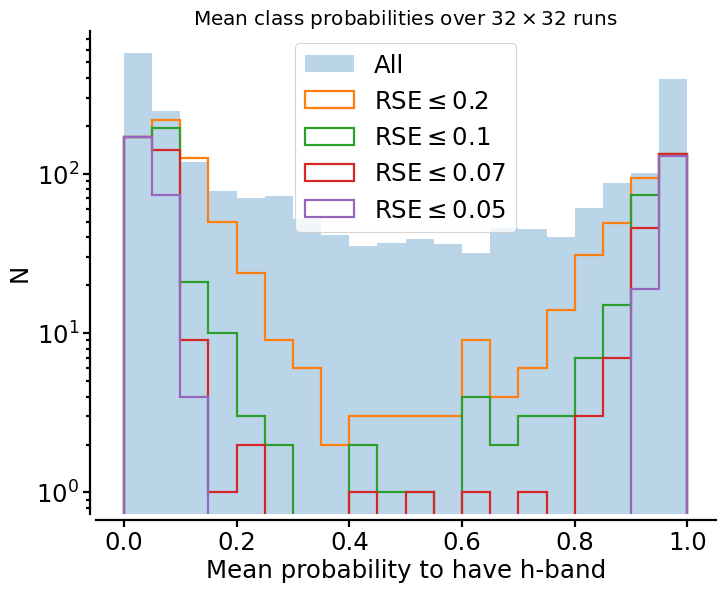

In [6]:
fig, axD = plt.subplots(1, 1, figsize=(10, 8))
apply_tufte(axD)

nbins = 20
rselims = [0.2, 0.1, 0.07, 0.05]

axD.hist(
    hssoparams.hband_median_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for rselim in rselims:
    axD.hist(
        hssoparams.hband_mean_prob[hssoparams.hband_rse_prob <= rselim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\mathrm{{RSE}}\leq{rselim}$",
    )
axD.set_xlabel("Mean probability to have h-band")
axD.set_ylabel("N")
axD.set_title(
    rf"Mean class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axD.legend()

plt.show()

Next we look at the plots of $\zeta$ vs. $\theta$ for both the full set of C-type classified asteroids and the h-band/ no h-band training sample (with known classes).

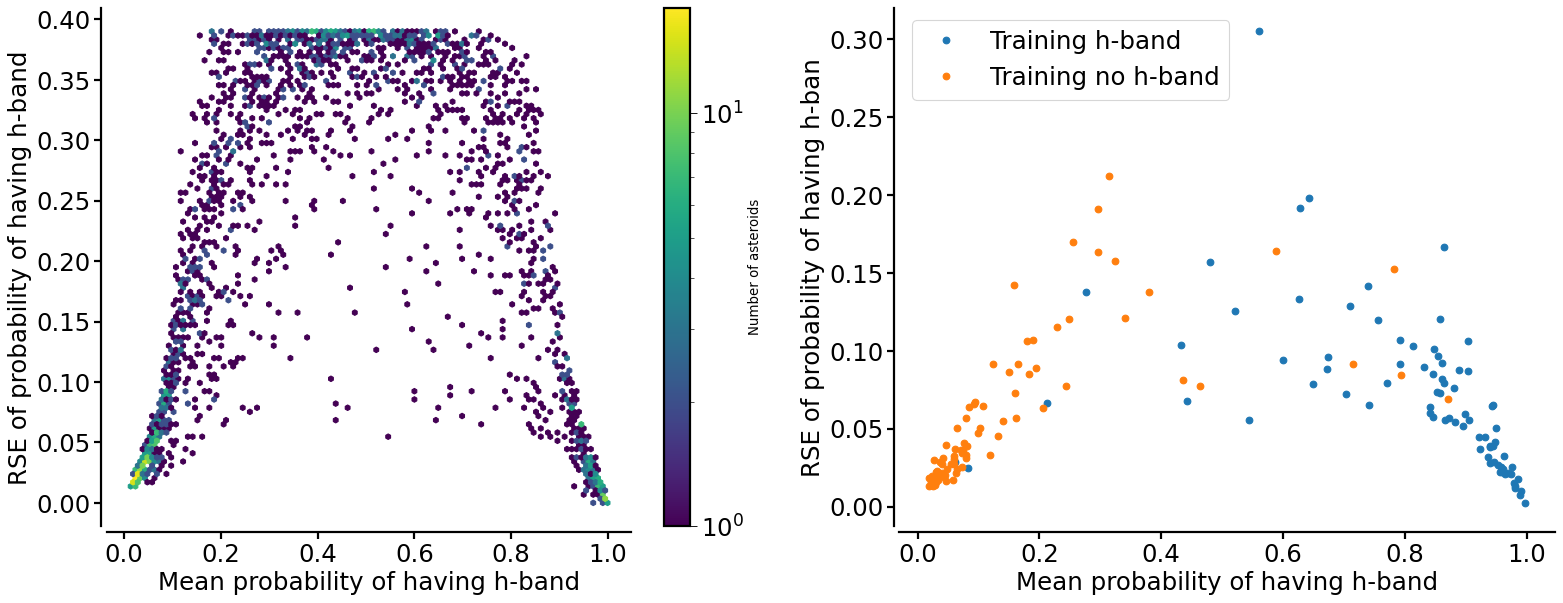

In [7]:
fig = plt.figure(figsize=(2 * 10, 8), tight_layout=True)
gs = GridSpec(1, 2, figure=fig)
axprobsh = []
axprobsh.append(fig.add_subplot(gs[0, 0]))
axprobsh.append(fig.add_subplot(gs[0, 1]))
for axx in axprobsh:
    apply_tufte(axx)

p_hband = hssoparams.hband_mean_prob[np.isin(hssoparams.number_mp, ssotypes["C_h"])]
rse_hband = hssoparams.hband_rse_prob[np.isin(hssoparams.number_mp, ssotypes["C_h"])]

p_no_hband = hssoparams.hband_mean_prob[
    np.isin(hssoparams.number_mp, ssotypes["C_no_h"])
]
rse_no_hband = hssoparams.hband_rse_prob[
    np.isin(hssoparams.number_mp, ssotypes["C_no_h"])
]

im = axprobsh[0].hexbin(
    hssoparams.hband_mean_prob, hssoparams.hband_rse_prob, mincnt=1, bins="log"
)
axprobsh[0].set_xlabel("Mean probability of having h-band")
axprobsh[0].set_ylabel("RSE of probability of having h-band")
cbarh = fig.colorbar(im, ax=axprobsh[0])
cbarh.set_label("Number of asteroids", fontsize=12)

axprobsh[1].plot(p_hband, rse_hband, "o", label="Training h-band")
axprobsh[1].plot(p_no_hband, rse_no_hband, "o", label="Training no h-band")
axprobsh[1].set_xlabel("Mean probability of having h-band")
axprobsh[1].set_ylabel("RSE of probability of having h-ban")
axprobsh[1].legend()

plt.show()

### Class definitions for hydration band
Based on the plots above one can opt for the following class definitions:
* C-type with h-band: $\theta\geq0.8$ and $\zeta\leq0.1$
* C-type without h-band: $\theta\leq0.2$ and $\zeta\leq0.1$

Now we look at example spectra of asteroids confidently classified as C-type with h-band or C-type without h-band according to the above criteria.

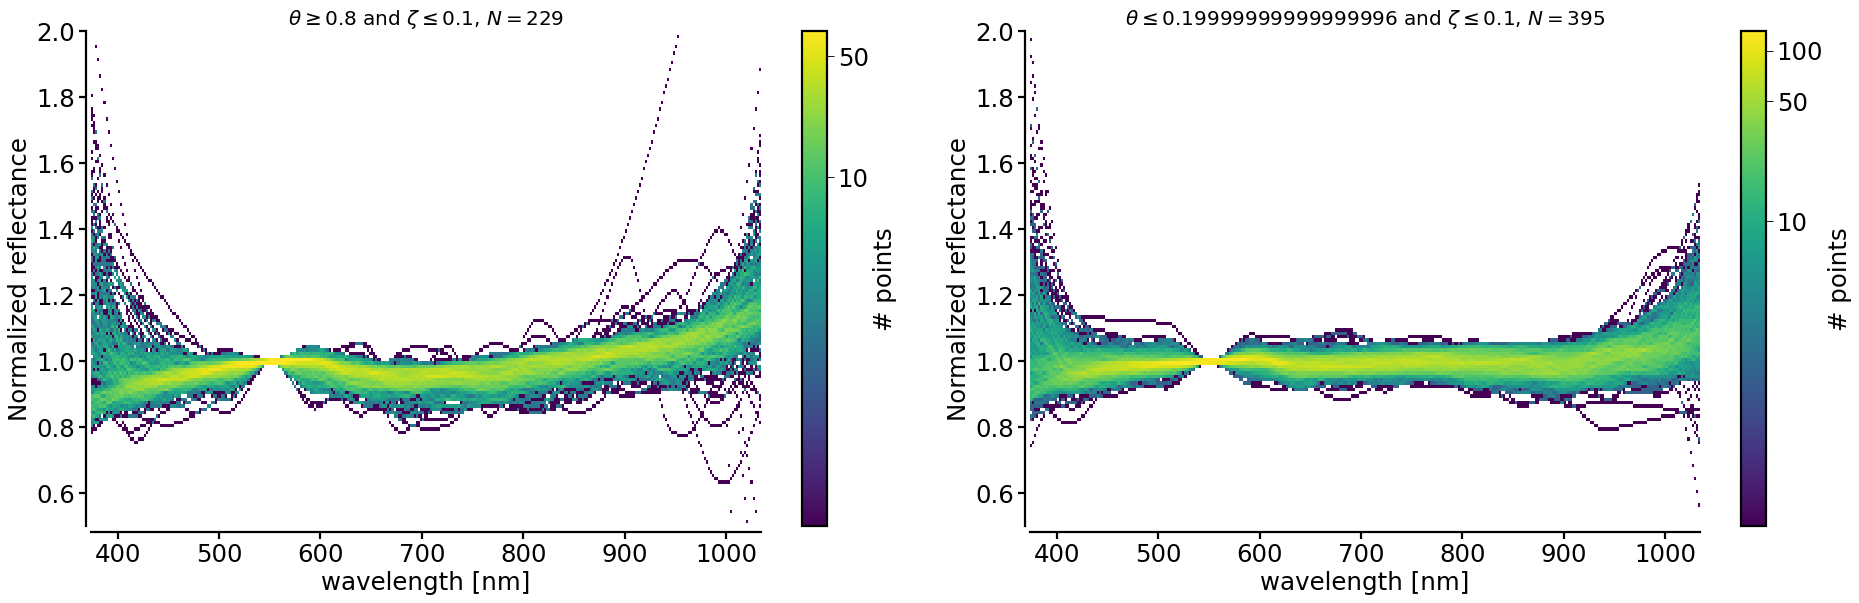

In [10]:
fig = plt.figure(figsize=(2 * 12, 8), tight_layout=True)
gs = GridSpec(1, 2, figure=fig)
axhspectra = []
axhspectra.append(fig.add_subplot(gs[0, 0]))
axhspectra.append(fig.add_subplot(gs[0, 1]))
for axx in axhspectra:
    apply_tufte(axx)

rsemax = 0.1
phband = 0.8
pnohband = 1.0 - phband

# Now separate with mean and standard deviation

hband_nums = hssoparams.number_mp[
    (hssoparams.hband_mean_prob >= phband) & (hssoparams.hband_rse_prob <= rsemax)
].to_list()
nohband_nums = hssoparams.number_mp[
    (hssoparams.hband_mean_prob <= pnohband) & (hssoparams.hband_rse_prob <= rsemax)
].to_list()

plot_spectra_collection(
    ssospectra, axhspectra[0], fig, hband_nums, cbarticks=[10, 50, 100]
)
axhspectra[0].set_title(
    rf"$\theta\geq{phband}$ and $\zeta\leq{rsemax}$, $N={len(hband_nums)}$", fontsize=18
)

plot_spectra_collection(
    ssospectra, axhspectra[1], fig, nohband_nums, cbarticks=[10, 50, 100, 1000]
)
axhspectra[1].set_title(
    rf"$\theta\leq{pnohband}$ and $\zeta\leq{rsemax}$, $N={len(nohband_nums)}$",
    fontsize=18,
)

plt.show()